In [229]:
import xgboost as xgb
import warnings


warnings.filterwarnings("ignore")


In [230]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance
from matplotlib import pyplot


In [231]:
from xgboost import XGBClassifier
# load data
dataset = loadtxt(r'.\pima-indians-diabetes.csv', delimiter=",")


In [232]:
dataset.shape
dataset[:,7].shape

(768,)

In [233]:
X=dataset[:,0:8]
Y=dataset[:,8]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=test_size,random_state=7)


In [234]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, Y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, Y_test, enable_categorical=True)

# Cross-Validation

In [235]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=10,
   early_stopping_rounds=20
)



In [236]:
results.head()



,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.393525,0.002975,0.441846,0.014141
1,0.337773,0.005253,0.430053,0.016715
2,0.296586,0.005958,0.426638,0.021409


In [237]:
best_rmse = results['test-rmse-mean'].min()

best_rmse

0.42663773509683545

# Model-Training

In [279]:
n = 10000
evals_result = {}  # Create an empty dictionary to store the evaluation results
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   # Activate early stopping
   evals_result=evals_result,  # Pass the dictionary to store results
   early_stopping_rounds=100
)

[0]	validation-rmse:0.44020	train-rmse:0.39505


[100]	validation-rmse:0.43318	train-rmse:0.00422
[200]	validation-rmse:0.43359	train-rmse:0.00149
[240]	validation-rmse:0.43359	train-rmse:0.00149


In [282]:
# Extract the log loss and error (1 - accuracy) from evals_result
rmse_values = evals_result["validation"]["rmse"]


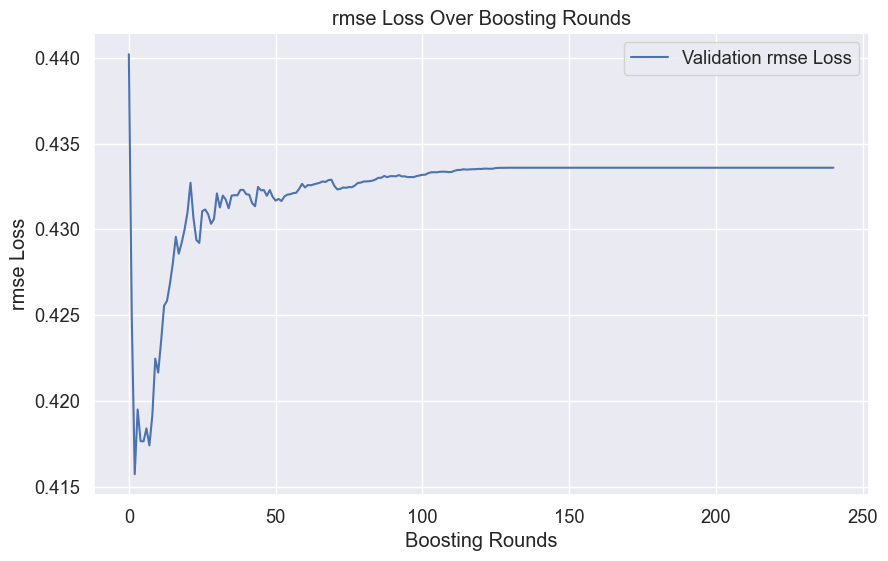

In [285]:
# Plot the log loss and error
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.title("rmse Loss Over Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("rmse Loss")
plt.plot(rmse_values, label="Validation rmse Loss")
plt.legend()



plt.show()

(30,)


<function matplotlib.pyplot.show(close=None, block=None)>

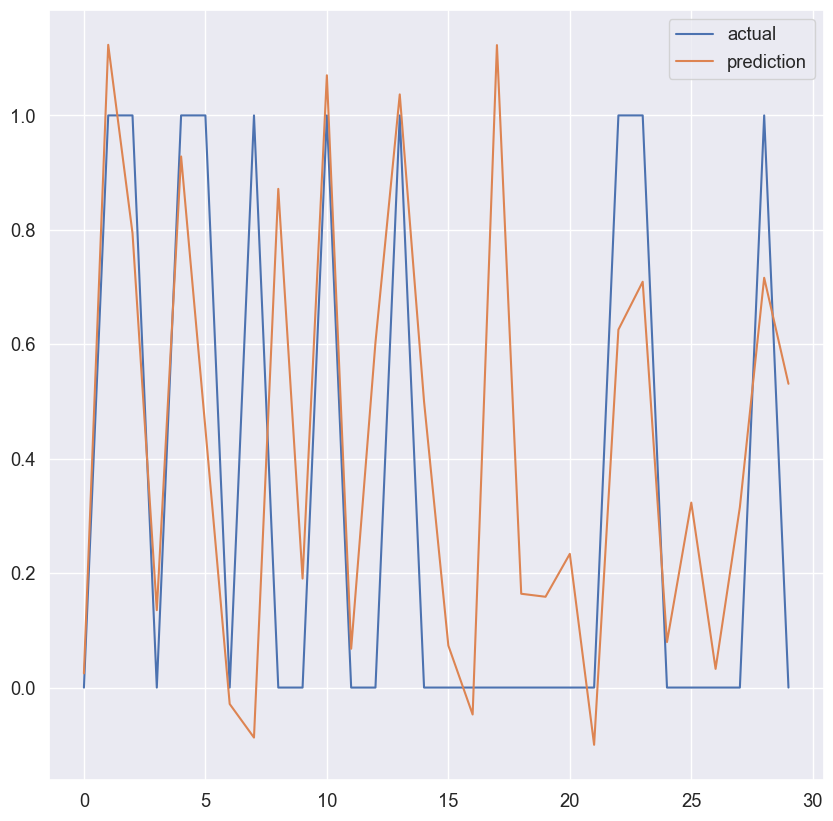

In [243]:
import matplotlib.pyplot as plt

Y_test=Y_test[:30,]
X_test=X_test[:30,]

print(Y_test.shape)

predict=xgb.DMatrix(X_test,Y_test,  enable_categorical=True)



# Make predictions on the test set
y_pred = model.predict(predict)
y_pred.shape




plt.figure(figsize=(10, 10))

plt.plot(range(len(Y_test)), Y_test, label='actual')
plt.plot(range(len(y_pred)), y_pred, label='prediction')
plt.legend()
plt.show

# Import Model

In [286]:
# load data
dataset = loadtxt(r'.\pima-indians-diabetes.csv', delimiter=",")
X=dataset[:,0:8]
Y=dataset[:,8]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=test_size,random_state=seed)
# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, Y_train), (X_test, Y_test)]
evals_result = {}  # Dictionary to store evaluation results


model.fit(
    X_train, 
    Y_train, 
    early_stopping_rounds=10, 
    eval_metric="rmse", 
    eval_set=eval_set,
    verbose=True,

    )
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate prediction
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-rmse:0.41154	validation_1-rmse:0.43984
[1]	validation_0-rmse:0.37076	validation_1-rmse:0.42121
[2]	validation_0-rmse:0.34396	validation_1-rmse:0.40877
[3]	validation_0-rmse:0.31882	validation_1-rmse:0.40223
[4]	validation_0-rmse:0.30258	validation_1-rmse:0.39740
[5]	validation_0-rmse:0.28303	validation_1-rmse:0.39659
[6]	validation_0-rmse:0.27187	validation_1-rmse:0.39832
[7]	validation_0-rmse:0.25943	validation_1-rmse:0.39785
[8]	validation_0-rmse:0.25063	validation_1-rmse:0.39741
[9]	validation_0-rmse:0.24384	validation_1-rmse:0.39711
[10]	validation_0-rmse:0.23461	validation_1-rmse:0.39618
[11]	validation_0-rmse:0.22314	validation_1-rmse:0.39537
[12]	validation_0-rmse:0.21850	validation_1-rmse:0.39901
[13]	validation_0-rmse:0.20961	validation_1-rmse:0.40091
[14]	validation_0-rmse:0.19990	validation_1-rmse:0.40541
[15]	validation_0-rmse:0.19622	validation_1-rmse:0.40450
[16]	validation_0-rmse:0.19201	validation_1-rmse:0.40597
[17]	validation_0-rmse:0.18459	validation

Accuracy: 79.13%


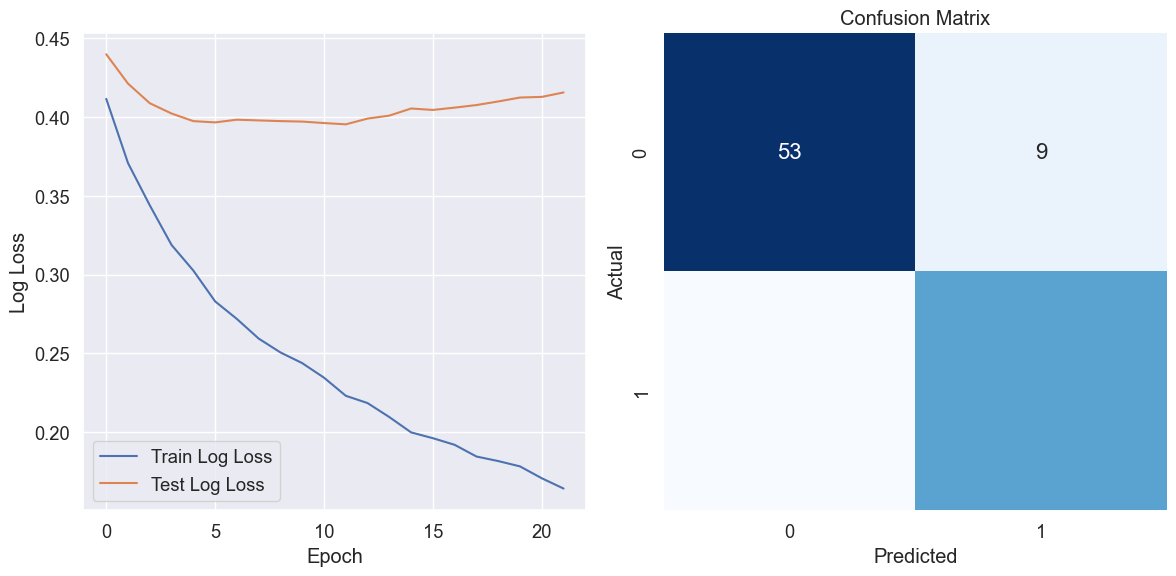

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract log loss values for training and test sets
results = model.evals_result()
train_logloss = results['validation_0']['rmse']
test_logloss = results['validation_1']['rmse']

X_test=X_test[:100,]
Y_test=Y_test[:100,]
# Make predictions on the test set
y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)

# Plot the log loss values over each epoch
plt.figure(figsize=(12, 6))


# Plot the log loss values over each epoch
plt.subplot(1, 2, 1)
plt.plot(range(len(train_logloss)), train_logloss, label='Train Log Loss')
plt.plot(range(len(test_logloss)), test_logloss, label='Test Log Loss')

# Set labels and legend
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

plt.subplot(1, 2, 2)
sns.set(font_scale=1.2)  # Adjust the font scale if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# Show the plot
plt.tight_layout()

plt.show()






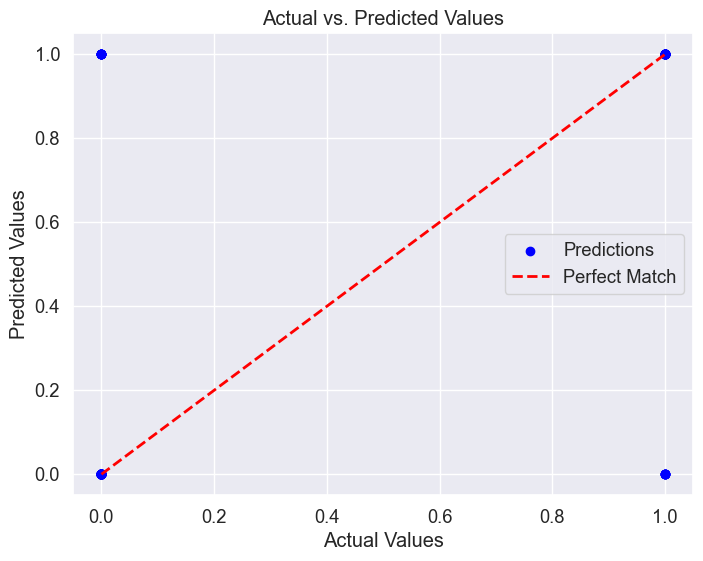

In [291]:
import matplotlib.pyplot as plt

# Assuming you have your model and predictions ready
# model: Your trained regression model
# y_pred: Predicted values
# y_actual: Actual target values
y_actual=Y_test
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, c='blue', label='Predictions')

# Add a line representing a perfect match (y_pred = y_actual)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', lw=2, label='Perfect Match')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

plt.show()


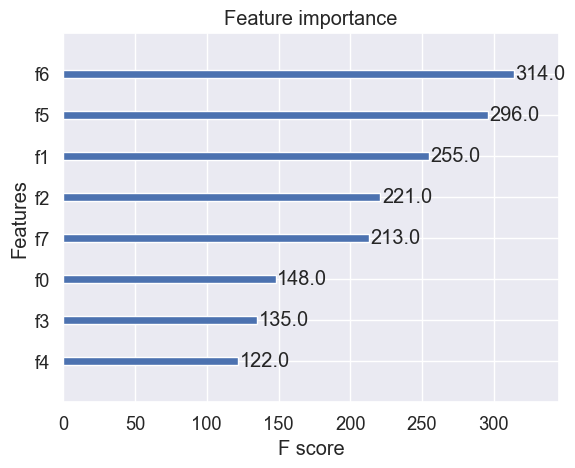

In [ ]:
# load data
dataset = loadtxt(r'.\pima-indians-diabetes.csv', delimiter=",")
X=dataset[:,0:8]
y=dataset[:,8]

# fit model no training data
model = XGBClassifier()
model.fit(X, y)
plot_importance(model)
pyplot.show()

In [ ]:
# load data
dataset = loadtxt(r'.\pima-indians-diabetes.csv', delimiter=",")
X=dataset[:,0:8]
Y=dataset[:,8]
# split data into train and test sets

# fit model no training data
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f with: %r" % (mean,param))



Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best: -0.246104 using {'learning_rate': 0.1}
-0.348941 with: {'learning_rate': 0.0001}
-0.348941 with: {'learning_rate': 0.001}
-0.256545 with: {'learning_rate': 0.01}
-0.246104 with: {'learning_rate': 0.1}
-0.257792 with: {'learning_rate': 0.2}
-0.270796 with: {'learning_rate': 0.3}
-0.270796 with: {'learning_rate': 0.4}


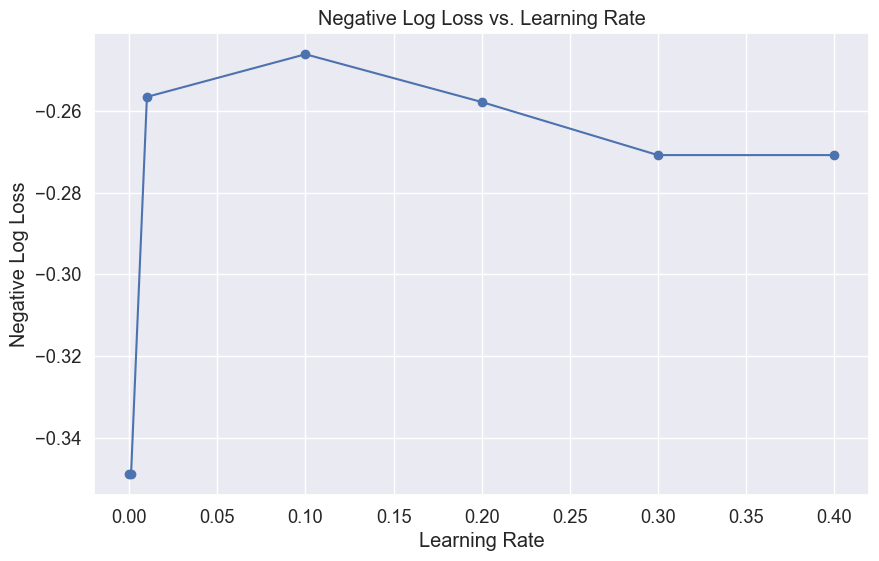

In [ ]:
import matplotlib.pyplot as plt

# Extract learning rates and corresponding mean test scores
learning_rates = [params['learning_rate'] for params in params]
mean_test_scores = means

# Plot the negative log loss vs. learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, mean_test_scores, marker='o', linestyle='-')
plt.title('Negative Log Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Negative Log Loss')
plt.grid(True)
plt.show()
